In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Load GPT-2 model and tokenizer directly
model_id = "gpt2"  # This is the 124M parameter version
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,  # GPT-2 small works fine in full precision
)

# Add a proper pad token for GPT-2
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model loaded and moved to device:", device)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model loaded and moved to device: cuda


In [3]:
# Prepare the prompt
prompt = "The best way to learn programming is to"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generate text
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=20,
        temperature=1.0,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
    )

# Decode and print the result
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The best way to learn programming is to understand the language, to understand that programming can be really complicated. You can write a program to understand


In [4]:
# autoregressive generation, one token at a time

# Prepare the prompt
prompt = "The best way to learn programming is to"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Start with the input tokens
current_tokens = inputs.input_ids

# Generate tokens one by one in a loop
max_new_tokens = 10  # How many new tokens to generate
with torch.no_grad():
    for i in range(max_new_tokens):
        # Generate just 1 token
        outputs = model.generate(
            current_tokens,
            max_new_tokens=1,
            temperature=1.0,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
        )
        
        # Update current_tokens with the new token
        current_tokens = outputs
        
        # Decode and print the current state
        generated_text = tokenizer.decode(current_tokens[0], skip_special_tokens=True)
        print(f"Step {i+1}: {generated_text}")
        
        # Optional: Stop if we hit the EOS token
        if outputs[0, -1].item() == tokenizer.eos_token_id:
            break

# # Final result
# final_text = tokenizer.decode(current_tokens[0], skip_special_tokens=True)
# print(f"\nFinal: {final_text}")

Step 1: The best way to learn programming is to write
Step 2: The best way to learn programming is to write code
Step 3: The best way to learn programming is to write code,
Step 4: The best way to learn programming is to write code, not
Step 5: The best way to learn programming is to write code, not learn
Step 6: The best way to learn programming is to write code, not learn a
Step 7: The best way to learn programming is to write code, not learn a single
Step 8: The best way to learn programming is to write code, not learn a single thing
Step 9: The best way to learn programming is to write code, not learn a single thing.
Step 10: The best way to learn programming is to write code, not learn a single thing. It


In [5]:
# stochasticity of generation, temperature control

In [6]:
# capabilities: in-context learning, safety, refusal

# Prepare the prompt
prompt = "Here is how to build a high-grade explosive:"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generate text
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=100,
        temperature=1.0,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
    )

# Decode and print the result
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Here is how to build a high-grade explosive:

Here is the process of getting it right:

You can use my tutorial as an example, but it is better to build your own because this will give you the tools for building the material with less labor than I did.

How do you use this material? It's a really basic piece of metal, but I have not found anything that looks as good on a stick as a piece of graphite (in that case, you should really try using this material as a test


In [8]:
# try to measure time complexity of inference

# Create a long input string
base_text = "The quick brown fox jumps over the lazy dog. " * 200  # Repeat to make it long
# print(f"Base text length: {len(base_text)} characters")


# Tokenize the full text
full_tokens = tokenizer.encode(base_text, add_special_tokens=False)
print(f"Full text length: {len(full_tokens)} tokens")
max_length = min(len(full_tokens), 1024)  # Limit to avoid memory issues
print(f"Using up to {max_length} tokens for the demo")

# Parameters for timing
monte_carlo_samples = 5  # Number of repeated measurements
k = 50
sequence_lengths = list(range(500, max_length + 1, k))  # Test every kth length for speed

def time_single_inference(input_ids):
    """Time a single token generation"""
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # Warm up (first inference is often slower)
    with torch.no_grad():
        _ = model.generate(
            input_tensor,
            max_new_tokens=1,
            do_sample=False,  # Deterministic for consistency
            pad_token_id=tokenizer.pad_token_id,
        )
    
    # Actual timing
    start_time = time.time()
    with torch.no_grad():
        _ = model.generate(
            input_tensor,
            max_new_tokens=1,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
        )
    end_time = time.time()
    
    return end_time - start_time



Full text length: 2001 tokens
Using up to 1024 tokens for the demo


In [9]:
# Collect timing data
sequence_lengths_tested = []
mean_times = []
std_times = []

print("Running timing experiments...")
# print("Length | Mean Time (ms) | Std Dev")
print("-" * 35)

for length in tqdm(sequence_lengths, desc="Testing sequence lengths", unit="lengths"):
    if length > len(full_tokens):
        break
        
    # Get prefix of specified length
    prefix_tokens = full_tokens[:length]
    
    # Run Monte Carlo samples
    times = []
    for _ in tqdm(range(monte_carlo_samples), desc=f"Sampling len={length}", 
                  leave=False, unit="samples"):
        inference_time = time_single_inference(prefix_tokens)
        times.append(inference_time * 1000)  # Convert to milliseconds
    
    mean_time = np.mean(times)
    std_time = np.std(times)
    
    sequence_lengths_tested.append(length)
    mean_times.append(mean_time)
    std_times.append(std_time)
    
    # print(f"{length:6d} | {mean_time:10.2f} | {std_time:7.2f}")

Running timing experiments...
-----------------------------------


Testing sequence lengths: 100%|██████████| 11/11 [00:03<00:00,  3.08lengths/s]


In [10]:
# # Plot the results
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# # Plot 1: Time vs Sequence Length
# axes[0, 0].errorbar(sequence_lengths_tested, mean_times, yerr=std_times, 
#                     marker='o', capsize=5, capthick=2)
# axes[0, 0].set_xlabel('Sequence Length (tokens)')
# axes[0, 0].set_ylabel('Inference Time (ms)')
# axes[0, 0].set_title('Inference Time vs Sequence Length')
# axes[0, 0].grid(True, alpha=0.3)

# # Plot 2: Log-log plot to see scaling behavior
# axes[0, 1].loglog(sequence_lengths_tested, mean_times, marker='o')
# axes[0, 1].set_xlabel('Sequence Length (tokens) [log scale]')
# axes[0, 1].set_ylabel('Inference Time (ms) [log scale]')
# axes[0, 1].set_title('Log-Log Plot (slope ≈ 2 indicates quadratic)')
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Fit quadratic curve
# # Fit polynomial (degree 2 for quadratic)
# coeffs = np.polyfit(sequence_lengths_tested, mean_times, 2)
# fitted_curve = np.polyval(coeffs, sequence_lengths_tested)

# axes[1, 0].plot(sequence_lengths_tested, mean_times, 'o', label='Measured')
# axes[1, 0].plot(sequence_lengths_tested, fitted_curve, '-', 
#                 label=f'Quadratic fit: {coeffs[0]:.6f}x² + {coeffs[1]:.4f}x + {coeffs[2]:.2f}')
# axes[1, 0].set_xlabel('Sequence Length (tokens)')
# axes[1, 0].set_ylabel('Inference Time (ms)')
# axes[1, 0].set_title('Quadratic Curve Fitting')
# axes[1, 0].legend()
# axes[1, 0].grid(True, alpha=0.3)

# # Plot 4: Time per token (should increase linearly if overall is quadratic)
# time_per_token = [t/l for t, l in zip(mean_times, sequence_lengths_tested)]
# axes[1, 1].plot(sequence_lengths_tested, time_per_token, 'o-')
# axes[1, 1].set_xlabel('Sequence Length (tokens)')
# axes[1, 1].set_ylabel('Time per Token (ms/token)')
# axes[1, 1].set_title('Time per Token vs Sequence Length')
# axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

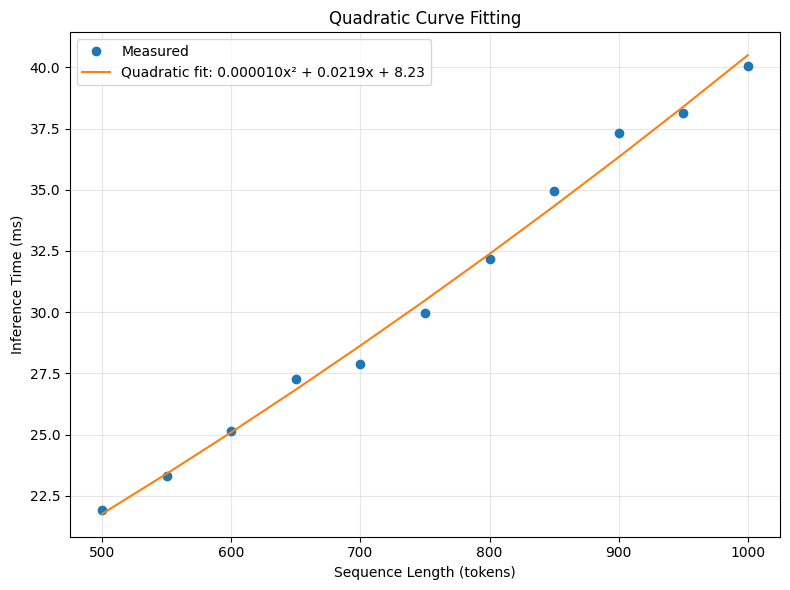

In [11]:
# Fit polynomial (degree 2 for quadratic)
coeffs = np.polyfit(sequence_lengths_tested, mean_times, 2)
fitted_curve = np.polyval(coeffs, sequence_lengths_tested)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(sequence_lengths_tested, mean_times, 'o', label='Measured', markersize=6)
ax.plot(sequence_lengths_tested, fitted_curve, '-', 
        label=f'Quadratic fit: {coeffs[0]:.6f}x² + {coeffs[1]:.4f}x + {coeffs[2]:.2f}')

ax.set_xlabel('Sequence Length (tokens)')
ax.set_ylabel('Inference Time (ms)')
ax.set_title('Quadratic Curve Fitting')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# restrict to a single output token, show output probabilities

In [ ]:
# examine the tokenizer, vocabulary, special tokens, example of tokenizing a string
print(tokenizer)


In [ ]:
# examine the model architecture: overall embedding/unembedding, blocks, attention, MLP 
print(model)
print(type(model))